In [1]:
import pandas as pd
import numpy as np
import datajoint as dj
dj.config['database.host'] = '10.86.1.219'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'retina'
dj.config["enable_python_native_blobs"] = True # Only for testing in dj0.12 (https://github.com/datajoint/datajoint-python#python-native-blobs)

%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
import os
os.chdir('..')
import main
drive_path = r"Z:\VEIDB/"
data_path = r"Y:\Data"
# data_path =r"V:\Data/"
# data_path =r"W:\Data/"

ft = main.load(drive_path, data_path)

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@10.86.1.219:3306


In [2]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('dark')

In [3]:
import ssm

ModuleNotFoundError: No module named 'ssm'

In [3]:
exp_table = ft.Experiment()
sess_table = ft.Session()
mouse_table = ft.Mouse()
subsess_table = ft.Subsession()
raw_tables = ft.ephys_tables.EphysRaw()
raw_helper_tables = ft.ephys_tables.EphysRawHelper()
subsess_events_table = ft.event_tables.SubsessionEvents()

sorted_table = ft.ephys_tables.SpikeSorted()
subsess_spikes_table = ft.ephys_tables.SubsessionSpikes()

trial_events_table = ft.event_tables.TrialEvents()
ball_table = ft.behavior_tables.BallReadout()

In [4]:
ball_table

experiment_id,mouse_id,session_id,subsession_id,ball_readout extracts the ball readout from wavesurfer channel,pxi_offset,pxi_scaling_factor
01230,M01,20200326a,CHPE_0009,=BLOB=,30064,0.66666
01230,M01,20200326a,DIMK_0013,=BLOB=,30059,0.666661
01230,M01,20200326a,DIMM_0004,=BLOB=,30066,0.666662
01230,M01,20200326a,EXPA_0002,=BLOB=,30067,0.666661
01230,M01,20200326a,EXPB_0014,=BLOB=,30069,0.666661
01230,M01,20200326a,EXPK_0010,=BLOB=,30059,0.666662
01230,M01,20200326a,EXPN_0007,=BLOB=,30059,0.666661
01230,M01,20200326a,EXPW_0005,=BLOB=,30064,0.66666
01230,M01,20200326a,MSSL_0008,=BLOB=,30063,0.666661
01230,M01,20200326a,SHRK_0011,=BLOB=,30059,0.66666


In [5]:
(ball_table & {'subsession_id': 'EXPA_0002'})

experiment_id,mouse_id,session_id,subsession_id,ball_readout extracts the ball readout from wavesurfer channel,pxi_offset,pxi_scaling_factor
01230,M01,20200326a,EXPA_0002,=BLOB=,30067,0.666661
01231,M01,20200327a,EXPA_0002,=BLOB=,30069,0.666661
01232,M01,20200328a,EXPA_0002,=BLOB=,30070,0.666662
01233,M01,20200329a,EXPA_0002,=BLOB=,30058,0.66666
01247,M01,20200328e,EXPA_0002,=BLOB=,30061,0.666659
01247,M01,20200328f,EXPA_0002,=BLOB=,30066,0.666662
01261,M01,20200327f,EXPA_0002,=BLOB=,30060,0.666661


In [74]:
# Get responses for each subsession
def get_ball_data(ball_readouts):
    ball_data = []
    stim_data = []
    for ball_readout in ball_readouts: # EXPW_0005, DIMM_0004, EXPA_0002
        ball_data.append(ball_readout[2])
        stim_data.append(ball_readout[1])
        print(ball_readout.shape)
    return ball_data, stim_data

def get_starts(stim_data):
    starts = []
    for stim in stim_data:
        starts.append(np.where(np.diff(stim_data[0])>5000)[0][1:-2][::3]) # Remove first pulse + last two pulses
    return starts

def get_responses(ball_data, stim_data, before=0, after=20000):
    responses = []
    starts = get_starts(stim_data)
    for trial, trial_starts in zip(ball_data, starts):
        trial_responses = []
        for start in trial_starts:
            trial_responses.append(trial[start-before:start+after])
        responses.append(trial_responses)
    responses = np.array(responses)-16800
    return responses
        
ball_readout_EXPW = (ball_table & {'experiment_id': '01233', 'subsession_id': 'EXPA_0002'}).fetch('ball_readout')
# ball_readout_EXPW = (ball_table & {'experiment_id': '01437', 'subsession_id': 'EXD_3_0001'}).fetch('ball_readout')
ball_data, stim_data = get_ball_data(ball_readout_EXPW)
responses = get_responses(ball_data, stim_data)

(4, 860000)


4791.673296872993


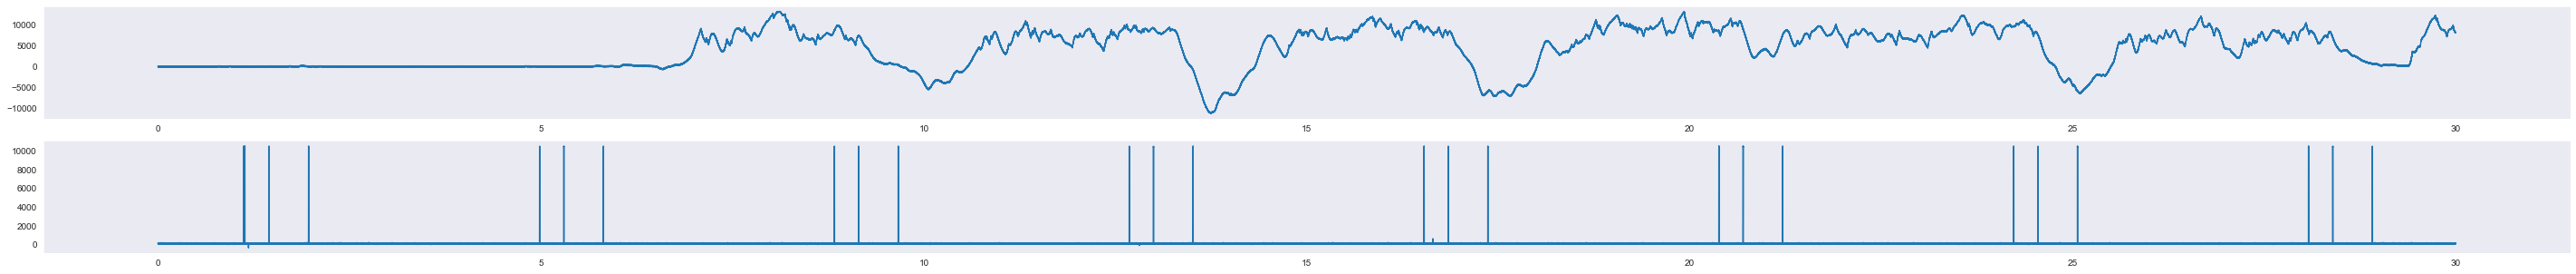

In [75]:
speed_0 = 16800
fig, axs = plt.subplots(2, 1, figsize=(50, 5))
for trial, stim in zip(ball_data, stim_data):
    trial = trial[20000*0:20000*30]
    stim = stim[20000*0:20000*30]
    print(np.std(trial-speed_0))
    axs[0].plot(np.arange(len(trial))/20000, trial-speed_0)
    axs[1].plot(np.arange(len(trial))/20000, stim)

In [8]:
np.where(np.diff(stim_data[0])>5000)[0] # Remove first pulse + last two pulses

array([ 22298,  62621,  68942,  79288, 139617, 145949, 156286, 216618,
       222948, 233284, 293616, 299946, 310284, 370615, 376945, 387282,
       447615, 453944, 464281, 524608, 530942, 541276, 601612, 607941,
       618275, 678610, 684940, 695277, 755608, 761938, 772276, 832326,
       832373], dtype=int64)

In [9]:
responses.shape

(7, 10, 40000)

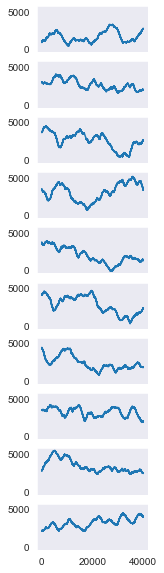

In [10]:
mean_responses = np.mean(responses, axis=0)

fig, axs = plt.subplots(mean_responses.shape[0], 1, sharey=True, sharex=True, figsize=(2, 10))
for i, mean_resp in enumerate(mean_responses):
    axs[i].plot(mean_resp)
#     plt.show()

# Clustering

In [133]:
# Get responses for each subsession
responses = []

ball_readouts_EXPW = (ball_table & {'subsession_id': 'EXPW_0005'}).fetch('ball_readout')
ball_readouts_DIMM = (ball_table & {'subsession_id': 'DIMM_0004'}).fetch('ball_readout')
ball_readouts_EXPA = (ball_table & {'subsession_id': 'EXPA_0002'}).fetch('ball_readout')
ball_readouts = np.concatenate([ball_readouts_EXPW, ball_readouts_DIMM, ball_readouts_EXPA])
# ball_readouts = ball_readouts_EXPA
# for ball_readout in ball_readouts: # EXPW_0005, DIMM_0004, EXPA_0002
ball_data, stim_data = get_ball_data(ball_readouts)
responses = get_responses(ball_data, stim_data, before=int(20000*2), after=int(20000*2))
# responses.extend(get_responses(ball_data, stim_data))
print(len(responses))
    
responses = np.array(responses)

(4, 900000)
(4, 860000)
(4, 900000)
(4, 900000)
(4, 900000)
(4, 900000)
(4, 900000)
(4, 860000)
(4, 860000)
(4, 860000)
(4, 860000)
(4, 860000)
(4, 860000)
(4, 860000)
(4, 860000)
(4, 860000)
(4, 860000)
(4, 860000)
(4, 860000)
(4, 860000)
(4, 860000)
21


In [134]:
from tslearn.clustering import TimeSeriesKMeans, KShape, KernelKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

In [135]:
responses.shape

(21, 10, 80000)

In [136]:
X = np.reshape(responses, (-1, responses.shape[-1], 1))
X.shape

(210, 80000, 1)

In [137]:
import scipy.signal

In [214]:
X_downsamp = scipy.signal.decimate(X, q=5, axis=1, zero_phase=True, ftype='fir')
X_downsamp = scipy.signal.decimate(X_downsamp, q=5, axis=1, zero_phase=True, ftype='fir')
X_downsamp = scipy.signal.decimate(X_downsamp, q=5, axis=1, zero_phase=True)
# for i in range(50):
#     X_downsamp = scipy.signal.decimate(X_downsamp, q=1, axis=1, zero_phase=True)
#     X_downsamp = scipy.signal.decimate(X_downsamp, q=1, axis=1, zero_phase=True)

# X_downsamp = scipy.signal.decimate(X_downsamp, q=5, axis=1, zero_phase=True)

print(X_downsamp.shape)

(210, 640, 1)


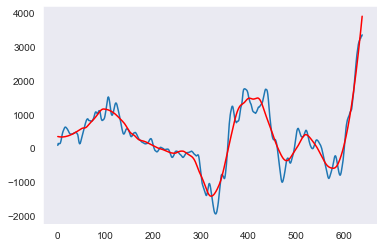

In [215]:
from scipy.signal import savgol_filter
plt.plot(X_downsamp[10,:,0])
X_downsamp = savgol_filter(X_downsamp, 101, 3, axis=1) # window size 101, polynomial order 3
plt.plot(X_downsamp[10], c='r')


In [216]:
def filter_trials(data, time_window, lower_thr=-np.inf, upper_thr=np.inf):
    sub = data[:,time_window[0]:time_window[1]]
    return np.any((sub >= lower_thr) & (sub < upper_thr), axis=1)

sub = X_downsamp[:,:,0]
trials_run = filter_trials(sub, [315, 325], lower_thr=10000) | filter_trials(sub, [315, 325], upper_thr=-10000)
trials_rest = filter_trials(sub, [315, 325], lower_thr=-10000, upper_thr=10000)

In [217]:
trials_run

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

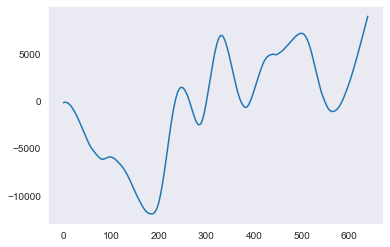

In [218]:
plt.plot(X_downsamp[42])

In [219]:
X_downsamp.shape

(210, 640, 1)

In [220]:
X_downsamp = X_downsamp[:,X_downsamp.shape[1]//2:,0]

In [221]:
from sklearn.decomposition import PCA
ncomponents = 10 #pca_components
pca = PCA(n_components=ncomponents)
pca.fit(X_downsamp)
X_pca = pca.transform(X_downsamp)

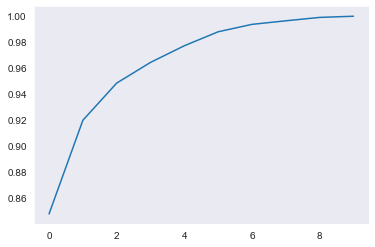

In [222]:
pca = PCA(n_components=10)
pca.fit(X_downsamp)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()


In [223]:
X_pca.shape

(210, 10)

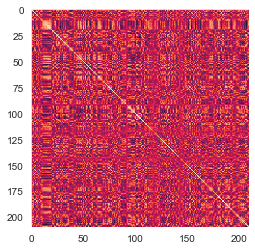

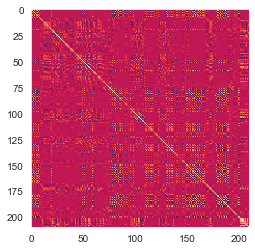

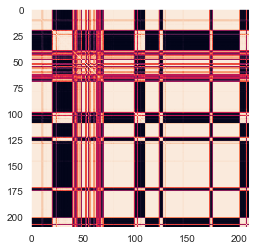

In [224]:
plt.imshow(np.corrcoef(X_downsamp[:,:]))
plt.show()
plt.imshow(np.corrcoef(X[:,:,0]))
plt.show()
plt.imshow(np.corrcoef(X_pca))
plt.show()

In [225]:
X.shape

(210, 80000, 1)

In [226]:
X_downsamp.shape

(210, 320)

In [168]:
# Expects: (num_series, max_length, 1)
n_clusters = 8
# X_downsamp = TimeSeriesResampler(sz=40).fit_transform(X_downsamp)

# X_downsamp = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_downsamp)
# km = KShape(n_clusters=n_clusters, n_init=1, random_state=0)
# km = KernelKMeans(n_clusters=n_clusters, kernel="gak", random_state=0)
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10000)
labels = km.fit_predict(X_downsamp)

In [228]:
from dtw import dtw

num_obs = X_downsamp.shape[0]
dist_mat = np.zeros(shape=(num_obs, num_obs))
for i in range(num_obs):
    print("Row", i)
    for j in range(num_obs):
#         print(X_downsamp[i,:,0])
#         print(dtw(X_downsamp[i,:,0], X_downsamp[j,:,0]).distance)
        dist_mat[i,j] = dtw(X_downsamp[i,:], X_downsamp[j,:]).distance

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133
Row 134
Row 135
Row 136
Row 137
Row 13

In [229]:
from sklearn.cluster import AgglomerativeClustering
n_clusters = 5
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='precomputed', linkage='complete').fit(dist_mat)
labels = clustering.labels_

In [230]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

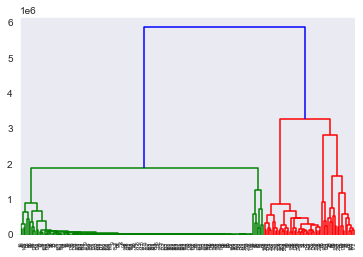

In [231]:
plot_dendrogram(clustering)

In [240]:
from sklearn.cluster import AgglomerativeClustering
n_clusters = 3
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='complete').fit(dist_mat)
labels = clustering.labels_

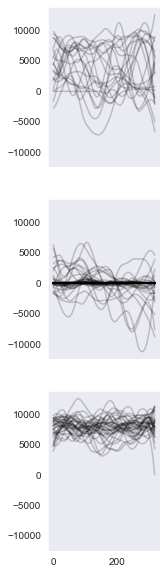

In [241]:
fig, axs = plt.subplots(n_clusters, 1, sharex=True, sharey=True, figsize=(2, 10))

for i in range(n_clusters):
    axs[i].plot(X_downsamp[labels==i].squeeze().T, "k-", alpha=.2)
#     axs[i].plot(km.cluster_centers_[i].squeeze(), "r-", linewidth=3)
#     axs[i].set(ylim=(-16800, 16800))
plt.show()

In [ ]:
# Get responses during entire stimulus set vs single presentations
### Get types of responses to expansion stimuli ...
### Get types of responses to dimming stimuli ...
### Get types of responese to bright expansion stimuli ...